# Estimating Macedonia's Counterfactual GDP Growth Under EU Membership
# A Synthetic Control and Predictive Modeling Approach

Research Question: What would North Macedonia's GDP per capita growth have been
if it had joined the EU in 2004 alongside other Central and Eastern European countries?

Methodology:
1. Synthetic Control Method (SCM) - Causal inference approach
2. Ridge Regression - Predictive modeling for validation
3. SHAP Analysis - Feature importance and interpretation
4. Placebo Tests - Statistical inference and robustness


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
data = pd.read_csv('../../data/processed/master_dataset.csv')

countries_of_interest = ['Estonia', 'Czechia', 'Slovenia', 'Poland', 'Hungary','Slovakia', 'Latvia', 'Lithuania', 'Malta', 'North Macedonia', 'Cyprus']

preferred_aggregations = {
    'HVGDP': '99',  # GDP per capita
    'UDGG': '99',   # Government debt
    'UVGM': '99',   # Manufacturing value added
    'PVGM': '99'    # Manufacturing price deflator
}

mask = pd.Series(False, index=data.index)
for var, agg in preferred_aggregations.items():
    pattern = rf'\.{agg}\..*\.{var}$'
    mask |= data['SERIES'].str.contains(pattern, regex=True)

filtered_data = data[mask]
filtered_data = filtered_data[filtered_data['COUNTRY'].isin(countries_of_interest)]

data = filtered_data[['COUNTRY', 'CODE', 'TITLE'] + [str(x) for x in range(1999, 2013)]]
data = data.melt(id_vars=['CODE', 'COUNTRY', 'TITLE'], var_name='DATE', value_name='VALUE')
data = data.pivot_table(
    index=['COUNTRY', 'DATE'],
    columns='CODE',
    values='VALUE'
).reset_index()

print(f"{data['DATE'].min()} - {data['DATE'].max()}")

1999 - 2012


In [4]:
data

CODE,COUNTRY,DATE,HVGDP,PVGM,UDGG,UVGM
0,Cyprus,1999,14.32901,76.034363,5.58,0.849175
1,Cyprus,2000,15.56856,80.842850,6.10,0.880511
2,Cyprus,2001,16.54016,84.514350,6.75,0.898750
3,Cyprus,2002,17.02760,86.036426,7.43,0.934455
4,Cyprus,2003,17.91890,84.683861,8.28,0.944811
...,...,...,...,...,...,...
149,Slovenia,2008,18.66598,91.160703,8.26,7.244000
150,Slovenia,2009,17.54962,91.753284,12.52,6.147630
151,Slovenia,2010,17.59587,87.705686,13.92,6.307510
152,Slovenia,2011,17.91772,90.558326,17.22,6.693200


In [5]:
df_pwt = pd.read_excel('../../data/original/pwt110.xlsx', sheet_name='Data')
df_pwt = df_pwt[['country', 'year', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'pl_gdpo', 'emp', 'rgdpo', 'cn']]
df_pwt = df_pwt[df_pwt['country'].isin(countries_of_interest)]
df_pwt = df_pwt[df_pwt['year'].isin(range(1999, 2013))]
df_pwt['trade_openness'] = df_pwt['csh_x'] + df_pwt['csh_m']

In [6]:
df_pwt

,country,year,csh_i,csh_g,csh_x,csh_m,pl_gdpo,emp,rgdpo,cn,trade_openness
3305,Cyprus,1999,0.247087,0.142285,0.121303,-0.463576,0.564441,0.259959,18532.789062,94510.687500,-0.342273
3306,Cyprus,2000,0.237955,0.131518,0.111937,-0.434116,0.477739,0.264221,21334.693359,96924.101562,-0.322178
3307,Cyprus,2001,0.221522,0.145064,0.111390,-0.449848,0.477630,0.270016,22322.181641,99760.109375,-0.338458
3308,Cyprus,2002,0.257353,0.157555,0.092098,-0.471888,0.533016,0.275743,21857.769531,99454.492188,-0.379790
3309,Cyprus,2003,0.247101,0.185203,0.094173,-0.490354,0.705893,0.285477,20135.355469,92240.968750,-0.396181
...,...,...,...,...,...,...,...,...,...,...,...
11528,Slovenia,2008,0.394546,0.195365,0.705098,-0.908888,0.837862,0.994990,71087.007812,323588.187500,-0.203790
11529,Slovenia,2009,0.283632,0.214973,0.607668,-0.720240,0.790439,0.974279,65633.859375,335510.125000,-0.112571
11530,Slovenia,2010,0.275903,0.215993,0.653093,-0.787755,0.758247,0.954647,66438.625000,363949.093750,-0.134662
11531,Slovenia,2011,0.267357,0.226647,0.708244,-0.848215,0.781416,0.938706,70125.164062,384745.187500,-0.139972


In [7]:
GDP_data = data[(data['DATE'].astype(int) >= 2004) & (data['DATE'].astype(int) <= 2012)][['COUNTRY', 'DATE', 'HVGDP']]

post_treatment_gdp = GDP_data.groupby('COUNTRY')['HVGDP'].mean()

print("\nAverage Post-Treatment GDP per capita (2004-2012):")
print(post_treatment_gdp.sort_values(ascending=False).round(2))
print(f"\nMacedonia's average: {post_treatment_gdp['North Macedonia']:.2f}")
print(f"Average EU accession country: {post_treatment_gdp.drop('North Macedonia').mean():.2f}")


Average Post-Treatment GDP per capita (2004-2012):
COUNTRY
Cyprus             22.31
Slovenia           16.70
Malta              14.91
Czechia            13.58
Estonia            10.90
Slovakia           10.69
Hungary             9.68
Lithuania           8.57
Latvia              8.39
Poland              8.33
North Macedonia     3.48
Name: HVGDP, dtype: float64

Macedonia's average: 3.48
Average EU accession country: 12.41


In [8]:
gdp_lag_years = [1999, 2000, 2001, 2002, 2003]

gdp_lags = (
    data[data['DATE'].astype(int).isin(gdp_lag_years)]
    .pivot(index='COUNTRY', columns='DATE', values='HVGDP')
)

gdp_lags.columns = [f'HVGDP_{int(c)}' for c in gdp_lags.columns]

In [9]:
data_2003 = data[data['DATE'] == '2003'].set_index('COUNTRY')
data_2003 = data_2003[['HVGDP', 'UDGG', 'UVGM', 'PVGM']].dropna()
data_2003 = data_2003.join(post_treatment_gdp.rename('GDP_post'))

model_data_single = data_2003[data_2003.index != 'North Macedonia']
model_data_single = model_data_single[model_data_single.index != 'Poland']
target_data_single = data_2003[data_2003.index == 'North Macedonia']

In [32]:
post_treatment_gdp

COUNTRY
Cyprus             22.309130
Czechia            13.581587
Estonia            10.895701
Hungary             9.680972
Latvia              8.391630
Lithuania           8.569116
Malta              14.906803
North Macedonia     3.484609
Poland              8.333504
Slovakia           10.691632
Slovenia           16.700712
Name: HVGDP, dtype: float64

In [10]:
data_ts = data[(data['DATE'].astype(int) >= 1999) & (data['DATE'].astype(int) <= 2003)].copy()
data_ts = data_ts[['COUNTRY', 'DATE', 'HVGDP', 'UDGG', 'UVGM', 'PVGM']].dropna()

pivot_list = []
for var in ['HVGDP', 'UDGG', 'UVGM', 'PVGM']:
    pivoted_var = data_ts.pivot(index='COUNTRY', columns='DATE', values=var)
    pivoted_var.columns = [f"{var}_{col}" for col in pivoted_var.columns]
    pivot_list.append(pivoted_var)

X_ts = pd.concat(pivot_list, axis=1)
X_ts = X_ts.join(post_treatment_gdp.rename('GDP_post'))

model_data_ts = X_ts[X_ts.index != 'North Macedonia'].dropna()
model_data_ts = model_data_ts[model_data_ts.index != 'Poland']
target_data_ts = X_ts[X_ts.index == 'North Macedonia'].dropna()

In [11]:
X_ts

,HVGDP_1999,HVGDP_2000,HVGDP_2001,HVGDP_2002,HVGDP_2003,UDGG_1999,UDGG_2000,UDGG_2001,UDGG_2002,UDGG_2003,...,UVGM_2000,UVGM_2001,UVGM_2002,UVGM_2003,PVGM_1999,PVGM_2000,PVGM_2001,PVGM_2002,PVGM_2003,GDP_post
COUNTRY,,,,,,,,,,,,,,,,,,,,,
Cyprus,14.32901,15.56856,16.54016,17.02760,17.91890,5.58,6.10,6.75,7.43,8.28,...,0.880511,0.898750,0.934455,0.944811,76.034363,80.842850,84.514350,86.036426,84.683861,22.309130
Czechia,5.97795,6.56201,7.44015,8.60691,8.72074,9.50,11.60,18.30,22.00,24.50,...,15.663240,17.889350,19.520580,19.178660,79.519502,82.840009,91.146373,95.240677,92.827460,13.581587
Estonia,3.92031,4.40422,5.01337,5.65584,6.36032,0.35,0.32,0.34,0.44,0.49,...,0.954580,1.121440,1.225940,1.376970,60.195996,60.858351,63.203856,64.270774,67.157704,10.895701
Hungary,4.50519,5.02401,5.89625,7.06651,7.43811,27.60,28.00,32.80,41.00,42.30,...,9.789400,11.506610,13.315960,14.013440,58.741852,61.768987,69.420221,74.910838,72.729729,9.680972
Latvia,2.86614,3.55524,3.92815,4.25912,4.38344,0.90,1.01,1.30,1.25,1.41,...,1.174539,1.275340,1.377091,1.297695,47.894590,55.183523,55.923836,54.179301,49.464485,8.391630
Lithuania,2.93387,3.57297,3.94450,4.40804,4.88245,2.48,2.91,3.19,3.37,3.40,...,2.121720,2.382780,2.495100,2.803070,63.916254,76.399366,75.965753,75.736568,74.967164,8.569116
Malta,NaN,11.33340,11.56286,11.92805,12.03172,NaN,2.65,2.99,2.93,3.27,...,0.849889,0.720425,0.738125,0.739331,NaN,93.450859,95.805179,94.412965,88.917371,14.906803
North Macedonia,2.02838,2.27961,2.29717,2.35527,2.44128,1.10,1.86,1.87,1.71,1.60,...,0.367231,0.371448,0.357727,0.391725,50.847405,51.311199,55.034175,51.481815,51.662465,3.484609
Poland,4.18588,4.90209,5.59087,5.52462,5.05825,63.10,70.70,83.30,84.20,83.90,...,29.865000,30.800300,29.861100,29.737200,98.145289,109.556938,114.463724,108.706887,96.234253,8.333504


In [12]:
print("Feature Selection (1999 & 2003 only):")
selected_features = []
for var in ['HVGDP', 'UDGG', 'UVGM', 'PVGM']:
    selected_features.append(f"{var}_1999")
    selected_features.append(f"{var}_2003")

model_data_selected = model_data_ts[selected_features + ['GDP_post']]
target_data_selected = target_data_ts[selected_features + ['GDP_post']]

print(f"    Donor countries: {len(model_data_selected)}")
print(f"    Features: {len(selected_features)} (first and last year only)")
print(f"    Feature-to-donor ratio: {len(selected_features)}/{len(model_data_selected)} = "
      f"{len(selected_features)/len(model_data_selected):.2f}")

Feature Selection (1999 & 2003 only):
    Donor countries: 8
    Features: 8 (first and last year only)
    Feature-to-donor ratio: 8/8 = 1.00


In [13]:
model_data_ameco_ts = model_data_ts.copy()
target_data_ameco_ts = target_data_ts.copy()

In [14]:
model_data_ts

,HVGDP_1999,HVGDP_2000,HVGDP_2001,HVGDP_2002,HVGDP_2003,UDGG_1999,UDGG_2000,UDGG_2001,UDGG_2002,UDGG_2003,...,UVGM_2000,UVGM_2001,UVGM_2002,UVGM_2003,PVGM_1999,PVGM_2000,PVGM_2001,PVGM_2002,PVGM_2003,GDP_post
COUNTRY,,,,,,,,,,,,,,,,,,,,,
Cyprus,14.32901,15.56856,16.54016,17.02760,17.91890,5.58,6.10,6.75,7.43,8.28,...,0.880511,0.89875,0.934455,0.944811,76.034363,80.842850,84.514350,86.036426,84.683861,22.309130
Czechia,5.97795,6.56201,7.44015,8.60691,8.72074,9.50,11.60,18.30,22.00,24.50,...,15.663240,17.88935,19.520580,19.178660,79.519502,82.840009,91.146373,95.240677,92.827460,13.581587
Estonia,3.92031,4.40422,5.01337,5.65584,6.36032,0.35,0.32,0.34,0.44,0.49,...,0.954580,1.12144,1.225940,1.376970,60.195996,60.858351,63.203856,64.270774,67.157704,10.895701
Hungary,4.50519,5.02401,5.89625,7.06651,7.43811,27.60,28.00,32.80,41.00,42.30,...,9.789400,11.50661,13.315960,14.013440,58.741852,61.768987,69.420221,74.910838,72.729729,9.680972
Latvia,2.86614,3.55524,3.92815,4.25912,4.38344,0.90,1.01,1.30,1.25,1.41,...,1.174539,1.27534,1.377091,1.297695,47.894590,55.183523,55.923836,54.179301,49.464485,8.391630
Lithuania,2.93387,3.57297,3.94450,4.40804,4.88245,2.48,2.91,3.19,3.37,3.40,...,2.121720,2.38278,2.495100,2.803070,63.916254,76.399366,75.965753,75.736568,74.967164,8.569116
Slovakia,3.62090,4.14179,4.43707,4.88974,5.56279,9.58,10.98,12.41,12.35,13.16,...,4.391460,5.00622,5.006760,5.810560,90.635997,104.506347,102.180634,99.323109,98.568359,10.691632
Slovenia,10.65298,10.92100,11.55556,12.37060,13.02659,4.92,5.48,6.04,6.71,6.94,...,4.705830,5.05888,5.333080,5.654840,96.048439,89.487056,91.858113,92.242264,91.970976,16.700712


In [15]:
target_data_ameco_ts

,HVGDP_1999,HVGDP_2000,HVGDP_2001,HVGDP_2002,HVGDP_2003,UDGG_1999,UDGG_2000,UDGG_2001,UDGG_2002,UDGG_2003,...,UVGM_2000,UVGM_2001,UVGM_2002,UVGM_2003,PVGM_1999,PVGM_2000,PVGM_2001,PVGM_2002,PVGM_2003,GDP_post
COUNTRY,,,,,,,,,,,,,,,,,,,,,
North Macedonia,2.02838,2.27961,2.29717,2.35527,2.44128,1.1,1.86,1.87,1.71,1.6,...,0.367231,0.371448,0.357727,0.391725,50.847405,51.311199,55.034175,51.481815,51.662465,3.484609


In [16]:
print("PWT Theoretical Features:")
df_pre = df_pwt[(df_pwt['year'] >= 1999) & (df_pwt['year'] <= 2003)].copy()

pivot_pwt = []
for var in ['csh_i', 'csh_g', 'trade_openness', 'pl_gdpo', 'emp', 'rgdpo', 'cn']:
    piv = df_pre.pivot(index='country', columns='year', values=var)
    piv.columns = [f"{var}_{col}" for col in piv.columns]
    pivot_pwt.append(piv)

X_pwt = pd.concat(pivot_pwt, axis=1)
X_pwt = X_pwt.join(post_treatment_gdp.rename('GDP_post'))

model_data_pwt = X_pwt[X_pwt.index != 'North Macedonia'].dropna()
model_data_pwt = model_data_pwt[model_data_pwt.index != 'Poland']
target_data_pwt = X_pwt[X_pwt.index == 'North Macedonia'].dropna()

print(f"    Donor countries: {len(model_data_pwt)}")
print(f"    Features: {len(model_data_pwt.columns[:-1])}")
print(f"    Feature-to-donor ratio: {len(model_data_pwt.columns[:-1])}/{len(model_data_pwt)} = "
      f"{len(model_data_pwt.columns[:-1])/len(model_data_pwt):.2f}")

PWT Theoretical Features:
    Donor countries: 9
    Features: 35
    Feature-to-donor ratio: 35/9 = 3.89


Summary Statistics (2003):
       HVGDP   UDGG   UVGM   PVGM  GDP_post
count   9.00   9.00   9.00   9.00      9.00
mean    8.93  11.53   5.76  80.14     12.86
std     4.53  13.73   6.56  15.53      4.55
min     4.38   0.49   0.74  49.46      8.39
25%     5.56   3.27   1.30  72.73      9.68
50%     7.44   6.94   2.80  84.68     10.90
75%    12.03  13.16   5.81  91.97     14.91
max    17.92  42.30  19.18  98.57     22.31

North Macedonia's Pre-Accession Profile (2003):
    HVGDP: 2.44  (Donor mean: 8.93, Z-score: -1.43)
    UDGG: 1.60  (Donor mean: 11.53, Z-score: -0.72)
    UVGM: 0.39  (Donor mean: 5.76, Z-score: -0.82)
    PVGM: 51.66  (Donor mean: 80.14, Z-score: -1.83)


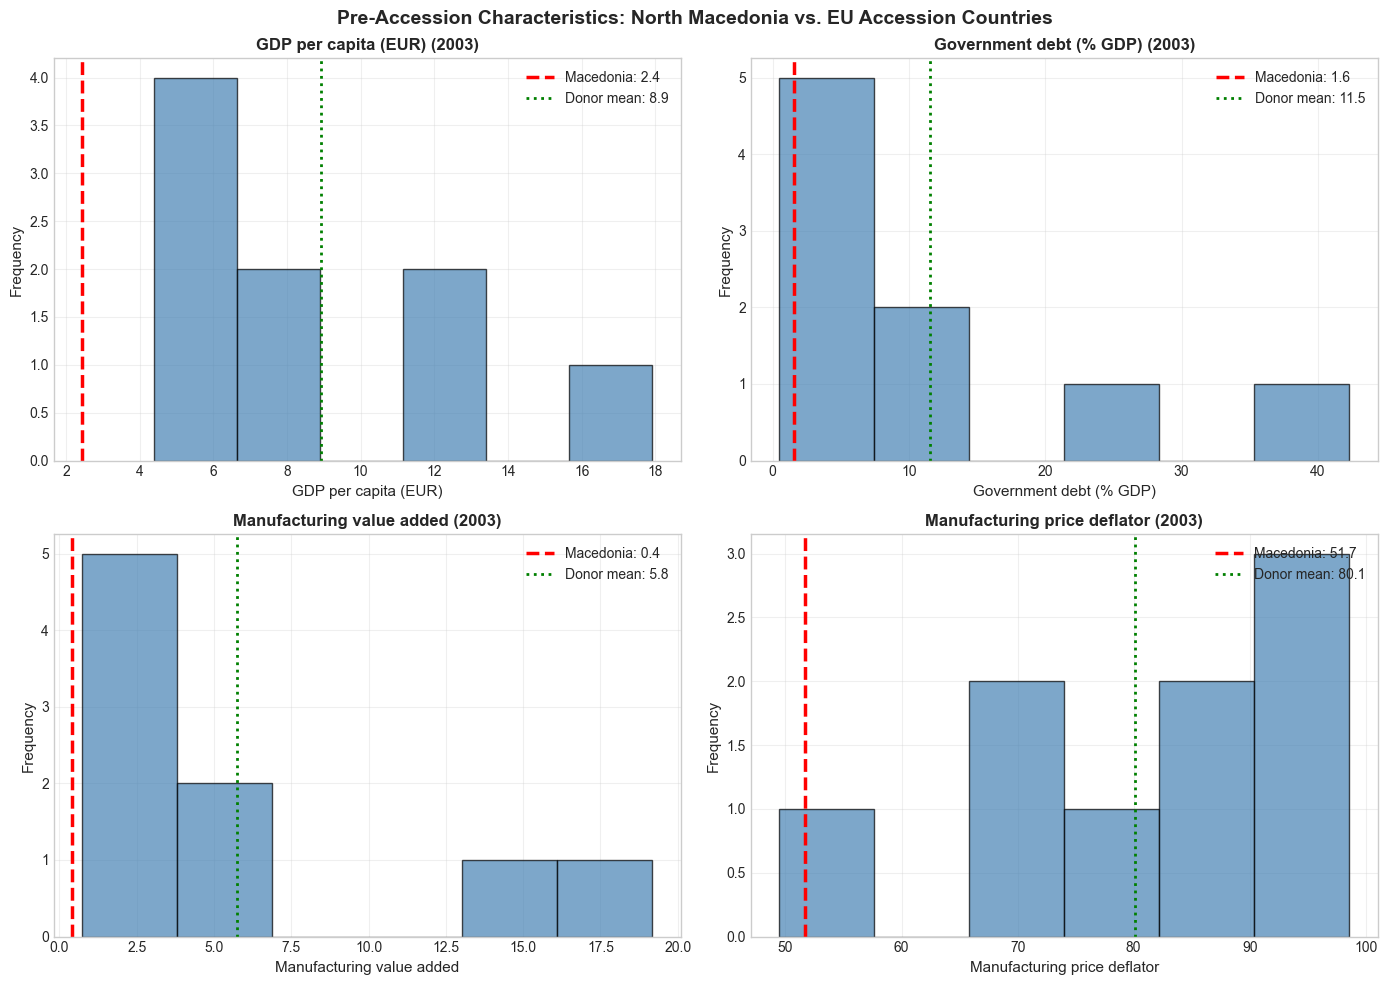

In [17]:
print("Summary Statistics (2003):")
print(model_data_single.describe().round(2), end='\n\n')

print("North Macedonia's Pre-Accession Profile (2003):")
for col in ['HVGDP', 'UDGG', 'UVGM', 'PVGM']:
    mkd_val = target_data_single[col].iloc[0]
    donor_mean = model_data_single[col].mean()
    donor_std = model_data_single[col].std()
    z_score = (mkd_val - donor_mean) / donor_std

    print(f"    {col}: {mkd_val:.2f}  (Donor mean: {donor_mean:.2f}, Z-score: {z_score:.2f})")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
features = ['HVGDP', 'UDGG', 'UVGM', 'PVGM']
feature_names = {
    'HVGDP': 'GDP per capita (EUR)',
    'UDGG': 'Government debt (% GDP)',
    'UVGM': 'Manufacturing value added',
    'PVGM': 'Manufacturing price deflator'
}

for idx, feature in enumerate(features):
    ax = axes[idx // 2, idx % 2]
    donor_vals = model_data_single[feature]
    mkd_val = target_data_single[feature].iloc[0]

    ax.hist(donor_vals, bins=6, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(mkd_val, color='red', linestyle='--', linewidth=2.5,
               label=f'Macedonia: {mkd_val:.1f}')
    ax.axvline(donor_vals.mean(), color='green', linestyle=':', linewidth=2,
               label=f'Donor mean: {donor_vals.mean():.1f}')

    ax.set_xlabel(feature_names[feature], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend(fontsize=10)
    ax.set_title(f'{feature_names[feature]} (2003)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Pre-Accession Characteristics: North Macedonia vs. EU Accession Countries',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../results/notebook-2/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. RIDGE REGRESSION: PREDICTIVE BASELINE

Ridge regression learns the relationship between pre-accession fundamentals (2003)
and post-accession growth (2004-2013) from EU countries, then predicts what
Macedonia's growth would have been under the same relationship.

This provides a predictive benchmark to validate the causal SCM estimates.

In [18]:
print("RIDGE REGRESSION ANALYSIS")

X_train = model_data_single.drop('GDP_post', axis=1)
y_train = model_data_single['GDP_post']
X_test = target_data_single.drop('GDP_post', axis=1)
y_test_ridge = target_data_single['GDP_post'].iloc[0]

scaler_ridge = StandardScaler()
X_train_scaled = scaler_ridge.fit_transform(X_train)
X_test_scaled = scaler_ridge.transform(X_test)

model_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
model_ridge.fit(X_train_scaled, y_train)

print(f"Best alpha (regularization): {model_ridge.alpha_}")

bootstrap_predictions = []
for _ in range(1000):
    X_bs, y_bs = resample(X_train_scaled, y_train, random_state=None)
    model_bs = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
    model_bs.fit(X_bs, y_bs)
    bootstrap_predictions.append(model_bs.predict(X_test_scaled)[0])

pred_mean = np.mean(bootstrap_predictions)
pred_ci_lower = np.percentile(bootstrap_predictions, 2.5)
pred_ci_upper = np.percentile(bootstrap_predictions, 97.5)

RIDGE REGRESSION ANALYSIS
Best alpha (regularization): 0.1


In [19]:
print("Leave-One-Out Cross-Validation Performance:", end='\n')

loo = LeaveOneOut()
loo_predictions = []
loo_actuals = []

for train_idx, test_idx in loo.split(X_train):
    X_loo_train, X_loo_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_loo_train, y_loo_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    scaler_loo = StandardScaler()
    X_loo_train_scaled = scaler_loo.fit_transform(X_loo_train)
    X_loo_test_scaled = scaler_loo.transform(X_loo_test)

    model_loo = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
    model_loo.fit(X_loo_train_scaled, y_loo_train)
    pred = model_loo.predict(X_loo_test_scaled)[0]

    loo_predictions.append(pred)
    loo_actuals.append(y_loo_test.iloc[0])

loo_df = pd.DataFrame({
    'country': X_train.index,
    'actual': loo_actuals,
    'predicted': loo_predictions,
    'error': np.array(loo_actuals) - np.array(loo_predictions)
})

mae = np.mean(np.abs(loo_df['error']))
rmse = np.sqrt(np.mean(loo_df['error'] ** 2))
r2 = 1 - np.sum(loo_df['error'] ** 2) / np.sum((loo_df['actual'] - np.mean(loo_df['actual'])) ** 2)

print(loo_df.round(2).to_string(index=False))
print(f"Cross-Validation Metrics:")
print(f"    MAE:  {mae:.2f} EUR")
print(f"    RMSE: {rmse:.2f} EUR")
print(f"    R2:   {r2:.2f}")

Leave-One-Out Cross-Validation Performance:
  country  actual  predicted  error
   Cyprus   22.31      19.28   3.03
  Czechia   13.58      11.00   2.58
  Estonia   10.90      10.48   0.41
  Hungary    9.68      16.03  -6.35
   Latvia    8.39       7.91   0.48
Lithuania    8.57       9.87  -1.30
    Malta   14.91      16.33  -1.42
 Slovakia   10.69       8.17   2.53
 Slovenia   16.70      16.92  -0.22
Cross-Validation Metrics:
    MAE:  2.03 EUR
    RMSE: 2.72 EUR
    R2:   0.60


In [20]:
print("RIDGE REGRESSION RESULTS: MACEDONIA COUNTERFACTUAL", end='\n\n')

print(f"Macedonia actual average GDP 2004-2012:     {y_test_ridge:.2f} EUR")
print(f"Predicted counterfactual GDP:               {pred_mean:.2f} EUR")
print(f"95% Confidence Interval:                    [{pred_ci_lower:.2f}, {pred_ci_upper:.2f}]")

gap_euros = pred_mean - y_test_ridge
gap_pct = (gap_euros / y_test_ridge) * 100

print(f"Estimated EU membership effect:             {gap_euros:+.2f} EUR ({gap_pct:+.2f}%)")
print(f"Effect 95% CI:                              [{pred_ci_lower - y_test_ridge:+.2f}, "
      f"{pred_ci_upper - y_test_ridge:+.2f}] EUR", end='\n\n')

print("Feature Coefficients (standardized):")
for feature, coef in zip(X_train.columns, model_ridge.coef_):
    direction = "Higher" if coef > 0 else "Lower"
    print(f"  {feature:10}: {coef:+.4f}  ({direction} → {'higher' if coef > 0 else 'lower'} GDP)")

RIDGE REGRESSION RESULTS: MACEDONIA COUNTERFACTUAL

Macedonia actual average GDP 2004-2012:     3.48 EUR
Predicted counterfactual GDP:               6.76 EUR
95% Confidence Interval:                    [4.85, 8.26]
Estimated EU membership effect:             +3.28 EUR (+94.03%)
Effect 95% CI:                              [+1.37, +4.78] EUR

Feature Coefficients (standardized):
  HVGDP     : +4.0669  (Higher → higher GDP)
  UDGG      : -0.8149  (Lower → lower GDP)
  UVGM      : +0.5523  (Higher → higher GDP)
  PVGM      : +0.2807  (Higher → higher GDP)


## 4. SYNTHETIC CONTROL METHOD: CAUSAL INFERENCE

SCM creates a "synthetic Macedonia" by weighting donor countries to match
Macedonia's pre-accession characteristics. The post-accession gap between
synthetic and actual Macedonia estimates the causal EU effect.

We test multiple specifications to address the curse of dimensionality.

In [21]:
def scm_optimize(X_donors, X_target):
    n_donors = X_donors.shape[0]
    V = np.ones(X_donors.shape[1]) / X_donors.shape[1]

    def objective(W):
        synthetic = W @ X_donors
        return np.sum(V * (X_target - synthetic) ** 2)

    constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})
    bounds = [(0, 1) for _ in range(n_donors)]
    W0 = np.ones(n_donors) / n_donors

    result = minimize(objective, W0, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 500, 'ftol': 1e-9})
    return result.x

def scm_optimize_regularized(X_donors, X_target, lambda_reg=1.0):
    n_donors = X_donors.shape[0]
    V = np.ones(X_donors.shape[1]) / X_donors.shape[1]

    def objective(W):
        synthetic = W @ X_donors
        fit_loss = np.sum(V * (X_target - synthetic) ** 2)
        reg_loss = lambda_reg * np.sum(W ** 2)
        return fit_loss + reg_loss

    constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})
    bounds = [(0, 1) for _ in range(n_donors)]
    W0 = np.ones(n_donors) / n_donors

    result = minimize(objective, W0, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 500, 'ftol': 1e-9})
    return result.x

def calculate_scm_metrics(weights, X_donors, X_target, y_donors):
    synthetic_pretreatment = weights @ X_donors
    mape = np.mean(np.abs((X_target - synthetic_pretreatment) / (np.abs(X_target) + 1e-6))) * 100
    synthetic_growth = weights @ y_donors
    active_countries = np.sum(weights > 0.01)

    return {
        'mape': mape,
        'synthetic_cagr': synthetic_growth,
        'active_countries': active_countries,
        'weights': weights
    }

results_scm = {}

In [22]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from itertools import combinations

data = pd.read_csv('../../data/processed/master_dataset.csv')
countries_of_interest = ['Estonia', 'Czechia', 'Slovenia', 'Poland', 'Hungary', 'Slovakia', 'Latvia', 'Lithuania',
                         'Malta', 'North Macedonia', 'Cyprus']

preferred_aggregations = {
    'HVGDP': '99',
    'UDGG': '99',
    'ZUTN': '0',
    'UXGS': '99',
    'UVGDR': '99',
    'PVGD': '99',
    'UVGE': '99',
    'UUNF': '99',
    'UUTT': '99',
    'UVGM': '99',
    'PVGM': '99',
    'XNE': '99',
    'UCPH': '99',
    'UCTH': '99',
}
mask = pd.Series(False, index=data.index)
for var, agg in preferred_aggregations.items():
    pattern = rf'\.{agg}\..*\.{var}$'
    mask |= data['SERIES'].str.contains(pattern, regex=True)

filtered_data = data[mask]
filtered_data = filtered_data[filtered_data['COUNTRY'].isin(countries_of_interest)]

data = filtered_data[['COUNTRY', 'CODE', 'TITLE'] + [str(x) for x in range(1999, 2013)]]
data = data.melt(id_vars=['CODE', 'COUNTRY', 'TITLE'], var_name='DATE', value_name='VALUE')
data = data.pivot_table(index=['COUNTRY', 'DATE'], columns='CODE', values='VALUE').reset_index()

GDP_data = data[(data['DATE'].astype(int) >= 2004) & (data['DATE'].astype(int) <= 2012)][['COUNTRY', 'DATE', 'HVGDP']]
post_treatment_gdp = GDP_data.groupby('COUNTRY')['HVGDP'].mean()

data_2003 = data[data['DATE'] == '2003'].set_index('COUNTRY')
eurostat_features = ['HVGDP', 'UDGG', 'PVGM', 'UVGE', 'UUNF', 'UUTT', 'UVGM', 'XNE', 'UCPH', 'UCTH', 'ZUTN']
data_2003 = data_2003[eurostat_features].dropna()
data_2003 = data_2003.join(post_treatment_gdp.rename('GDP_post'))

model_data_single = data_2003[data_2003.index != 'North Macedonia']
model_data_single = model_data_single[model_data_single.index != 'Poland']
target_data_single = data_2003[data_2003.index == 'North Macedonia']

def scm_optimize(X_donors, X_target):
    n_donors = X_donors.shape[0]
    V = np.ones(X_donors.shape[1]) / X_donors.shape[1]

    def objective(W):
        synthetic = W @ X_donors
        return np.sum(V * (X_target - synthetic) ** 2)

    constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})
    bounds = [(0, 1) for _ in range(n_donors)]
    W0 = np.ones(n_donors) / n_donors
    result = minimize(objective, W0, method='SLSQP', bounds=bounds, constraints=constraints, options={'maxiter': 500})
    return result.x

def count_active_countries(weights, threshold=0.05):
    return np.sum(weights > threshold)

def calculate_metrics(weights, X_donors, X_target, y_donors):
    synthetic_pretreatment = weights @ X_donors
    mape = np.mean(np.abs((X_target - synthetic_pretreatment) / (np.abs(X_target) + 1e-6))) * 100
    synthetic_gdp = weights @ y_donors
    return {'mape': mape, 'synthetic_gdp': synthetic_gdp, 'n_countries': count_active_countries(weights)}

def search_all_combinations_standard_scm(data, target_data, min_features=2, max_features=4):
    available_features = [col for col in data.columns
                         if col != 'GDP_post'
                         and pd.api.types.is_numeric_dtype(data[col])]

    print(f"EUROSTAT FEATURES AVAILABLE: {available_features}")
    print(f"Number of features: {len(available_features)}")

    y_donors = data['GDP_post'].values
    y_test = target_data['GDP_post'].iloc[0]
    results = []

    for n_features in range(min_features, min(max_features + 1, len(available_features) + 1)):
        for feature_combo in combinations(available_features, n_features):
            feature_list = list(feature_combo)
            try:
                X_donors_orig = data[feature_list].values
                X_target_orig = target_data[feature_list].values[0]

                scaler = StandardScaler()
                X_donors = scaler.fit_transform(X_donors_orig)
                X_target = scaler.transform(X_target_orig.reshape(1, -1))[0]

                weights = scm_optimize(X_donors, X_target)
                metrics = calculate_metrics(weights, X_donors, X_target, y_donors)

                country_weights = pd.DataFrame({'country': data.index, 'weight': weights}).sort_values('weight', ascending=False)
                top_countries = country_weights[country_weights['weight'] > 0.05]
                countries_01 = country_weights[country_weights['weight'] > 0.01]

                gap_euros = metrics['synthetic_gdp'] - y_test
                gap_pct = (gap_euros / y_test) * 100

                results.append({
                    'features': ', '.join(feature_list),
                    'n_features': len(feature_list),
                    'n_countries_5pct': metrics['n_countries'],
                    'n_countries_1pct': len(countries_01),
                    'max_weight': weights.max(),
                    'mape': metrics['mape'],
                    'synthetic_gdp': metrics['synthetic_gdp'],
                    'eu_effect_eur': gap_euros,
                    'eu_effect_pct': gap_pct,
                    'countries_5pct': '; '.join([f"{row['country']}:{row['weight']:.3f}" for _, row in top_countries.iterrows()]),
                    'countries_1pct': '; '.join([f"{row['country']}:{row['weight']:.3f}" for _, row in countries_01.iterrows()])
                })
            except Exception as e:
                continue

    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        results_df = results_df.sort_values(['n_countries_5pct', 'mape'], ascending=[False, True])
    return results_df

print("EUROSTAT-ONLY SCM ANALYSIS (2003 Data)", end='\n')

all_results = search_all_combinations_standard_scm(model_data_single, target_data_single, min_features=2, max_features=4)


print("\nALL FEATURE COMBINATIONS (STANDARD SCM):", end='\n')
print(all_results[['features', 'n_countries_5pct', 'n_countries_1pct',
                   'max_weight', 'mape', 'eu_effect_eur', 'eu_effect_pct', 'countries_5pct']])


print("\nCOMBINATIONS WITH 2+ COUNTRIES (>5% weight):")
multi_country = all_results[all_results['n_countries_5pct'] >= 2]
if len(multi_country) > 0:
    print(multi_country[['features', 'n_countries_5pct', 'mape', 'eu_effect_eur', 'eu_effect_pct', 'countries_5pct']])
else:
    print("No combinations found with 2+ countries at >5% weight threshold")

print("\nCOMBINATIONS WITH HVGDP (Sorted by MAPE):", end='\n\n')
hvgdp_combinations = all_results[all_results['features'].str.contains('HVGDP')]
hvgdp_combinations_sorted = hvgdp_combinations.sort_values('mape', ascending=True)
print(hvgdp_combinations_sorted[['features', 'n_countries_5pct', 'mape', 'eu_effect_eur', 'eu_effect_pct', 'countries_5pct']])


print("\nSUMMARY STATISTICS:", end='\n')
print(f"Total combinations tested: {len(all_results)}")
print(f"Average EU effect across all combos: {all_results['eu_effect_eur'].mean():.0f} EUR ({all_results['eu_effect_pct'].mean():.1f}%)")
print(f"Median EU effect: {all_results['eu_effect_eur'].median():.0f} EUR ({all_results['eu_effect_pct'].median():.1f}%)")
print(f"Min EU effect: {all_results['eu_effect_eur'].min():.0f} EUR ({all_results['eu_effect_pct'].min():.1f}%)")
print(f"Max EU effect: {all_results['eu_effect_eur'].max():.0f} EUR ({all_results['eu_effect_pct'].max():.1f}%)")
print(f"Combinations with 2+ countries: {(all_results['n_countries_5pct'] >= 2).sum()}")
print(f"Combinations with 3+ countries: {(all_results['n_countries_5pct'] >= 3).sum()}")

EUROSTAT-ONLY SCM ANALYSIS (2003 Data)
EUROSTAT FEATURES AVAILABLE: ['HVGDP', 'UDGG', 'PVGM', 'UVGE', 'UUNF', 'UUTT', 'UVGM', 'XNE', 'UCPH', 'UCTH', 'ZUTN']
Number of features: 11

ALL FEATURE COMBINATIONS (STANDARD SCM):
                  features  n_countries_5pct  n_countries_1pct  max_weight  \
362  UDGG, PVGM, XNE, UCPH                 3                 3    0.867911   
363  UDGG, PVGM, XNE, UCTH                 3                 3    0.870355   
420  UDGG, XNE, UCPH, UCTH                 3                 3    0.510556   
398  UDGG, UUNF, XNE, UCPH                 3                 3    0.544303   
399  UDGG, UUNF, XNE, UCTH                 3                 3    0.585048   
..                     ...               ...               ...         ...   
181        UVGE, XNE, ZUTN                 1                 1    1.000000   
212        UVGM, XNE, ZUTN                 1                 1    1.000000   
206        UUTT, XNE, ZUTN                 1                 1    1.000000  

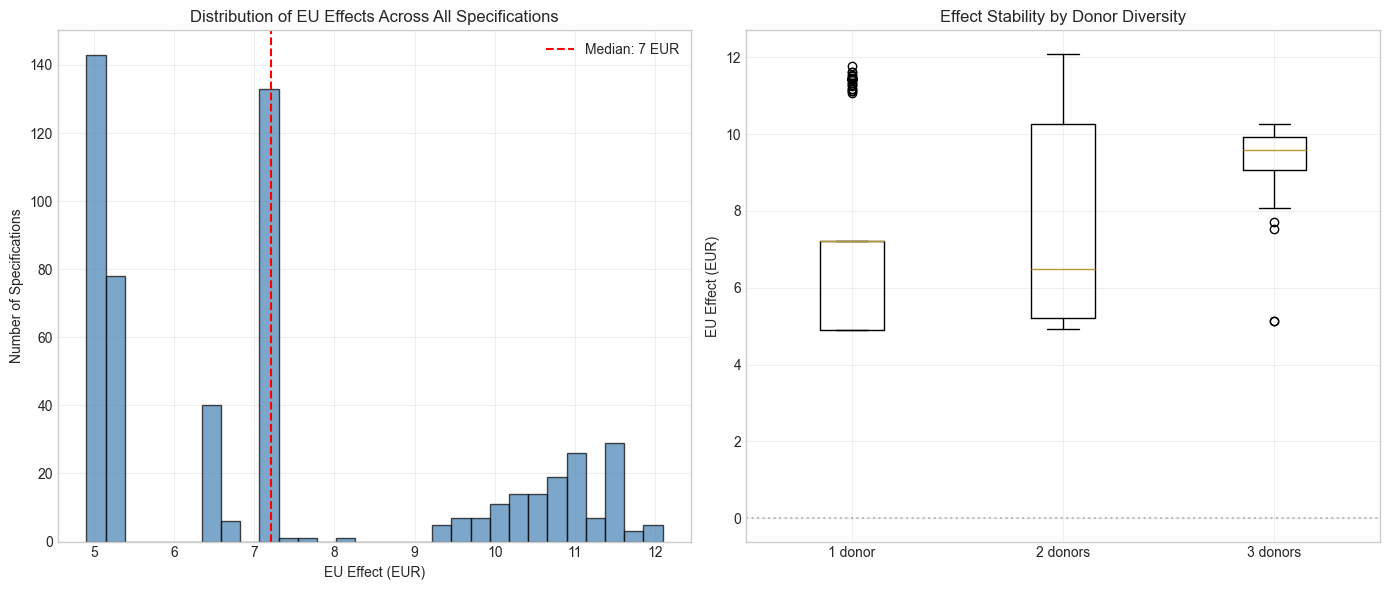

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(all_results['eu_effect_eur'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(all_results['eu_effect_eur'].median(), color='red', linestyle='--',
                label=f'Median: {all_results["eu_effect_eur"].median():.0f} EUR')
axes[0].set_xlabel('EU Effect (EUR)')
axes[0].set_ylabel('Number of Specifications')
axes[0].set_title('Distribution of EU Effects Across All Specifications')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

boxplot_data = []
labels_list = []
for n in sorted(all_results['n_countries_5pct'].unique()):
    subset = all_results[all_results['n_countries_5pct'] == n]['eu_effect_eur']
    if len(subset) > 0:
        boxplot_data.append(subset)
        labels_list.append(f'{int(n)} donor{"s" if n > 1 else ""}')

axes[1].boxplot(boxplot_data, labels=labels_list)
axes[1].axhline(y=0, color='gray', linestyle=':', alpha=0.5)
axes[1].set_ylabel('EU Effect (EUR)')
axes[1].set_title('Effect Stability by Donor Diversity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/notebook-2/sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
primary_spec_result = all_results[all_results['features'] == 'HVGDP, UDGG, PVGM']
if len(primary_spec_result) > 0:
    primary_eur = primary_spec_result.iloc[0]['eu_effect_eur']
    primary_pct = primary_spec_result.iloc[0]['eu_effect_pct']
else:
    hvgdp_specs = all_results[all_results['features'].str.contains('HVGDP')].sort_values('mape')
    primary_eur = hvgdp_specs.iloc[0]['eu_effect_eur']
    primary_pct = hvgdp_specs.iloc[0]['eu_effect_pct']

summary_table = pd.DataFrame({
    'Statistic': [
        'Number of specifications tested',
        'Mean effect across all specs',
        'Median effect across all specs',
        'Minimum effect (any spec)',
        'Maximum effect (any spec)',
        'Specs with positive effects',
        'Specs with HVGDP (positive)',
        'Best-fitting HVGDP spec (our primary)'
    ],
    'Value': [
        len(all_results),
        f"{all_results['eu_effect_eur'].mean():.0f} EUR ({all_results['eu_effect_pct'].mean():.2f}%)",
        f"{all_results['eu_effect_eur'].median():.0f} EUR ({all_results['eu_effect_pct'].median():.2f}%)",
        f"{all_results['eu_effect_eur'].min():.0f} EUR ({all_results['eu_effect_pct'].min():.2f}%)",
        f"{all_results['eu_effect_eur'].max():.0f} EUR ({all_results['eu_effect_pct'].max():.2f}%)",
        f"{(all_results['eu_effect_eur'] > 0).sum()} ({((all_results['eu_effect_eur'] > 0).sum()/len(all_results)*100):.2f}%)",
        f"{(all_results[all_results['features'].str.contains('HVGDP')]['eu_effect_eur'] > 0).sum()}",
        f"{primary_eur:.0f} EUR ({primary_pct:.2f}%)"
    ]
})

print("\nAppendix Table: Exhaustive Specification Testing")
print(summary_table.to_string(index=False))


Appendix Table: Exhaustive Specification Testing
                            Statistic            Value
      Number of specifications tested              550
         Mean effect across all specs  7 EUR (208.05%)
       Median effect across all specs  7 EUR (206.82%)
            Minimum effect (any spec)  5 EUR (140.82%)
            Maximum effect (any spec) 12 EUR (347.05%)
          Specs with positive effects    550 (100.00%)
          Specs with HVGDP (positive)              175
Best-fitting HVGDP spec (our primary)  5 EUR (141.17%)


In [31]:
target_data_single['GDP_post'].iloc[0]

np.float64(3.484608888888889)

In [25]:
print("SPECIFICATION 1: SINGLE-YEAR SCM (2003 FEATURES)")

X_donors_1 = model_data_single.drop('GDP_post', axis=1).values
y_donors_1 = model_data_single['GDP_post'].values
X_target_1 = target_data_single.drop('GDP_post', axis=1).values[0]
y_test_scm = target_data_single['GDP_post'].iloc[0]

scaler_1 = StandardScaler()
X_donors_1_scaled = scaler_1.fit_transform(X_donors_1)
X_target_1_scaled = scaler_1.transform(X_target_1.reshape(1, -1))[0]

weights_1 = scm_optimize(X_donors_1_scaled, X_target_1_scaled)
metrics_1 = calculate_scm_metrics(weights_1, X_donors_1_scaled, X_target_1_scaled, y_donors_1)

results_scm['single'] = {
    'weights': weights_1,
    'metrics': metrics_1,
    'countries': model_data_single.index,
    'y_test': y_test_scm
}

weights_df_1 = pd.DataFrame({
    'country': model_data_single.index,
    'weight': weights_1
}).sort_values('weight', ascending=False)

print("\nSynthetic Control Weights:")
print(weights_df_1[weights_df_1['weight'] > 0.01].round(4).to_string(index=False))

gap_euros = metrics_1['synthetic_cagr'] - y_test_scm
gap_pct = (gap_euros / y_test_scm) * 100

print(f"\nResults:")
print(f"    Synthetic Macedonia GDP: {metrics_1['synthetic_cagr']:.2f} EUR")
print(f"    Actual Macedonia GDP:    {y_test_scm:.2f} EUR")
print(f"    EU membership effect:    {gap_euros:+.2f} EUR ({gap_pct:+.1f}%)")
print(f"    Pre-treatment fit (MAPE): {metrics_1['mape']:.2f}%")
print(f"    Active donors (>1%):      {metrics_1['active_countries']}")

SPECIFICATION 1: SINGLE-YEAR SCM (2003 FEATURES)

Synthetic Control Weights:
 country  weight
Slovakia   0.546
  Latvia   0.454

Results:
    Synthetic Macedonia GDP: 9.65 EUR
    Actual Macedonia GDP:    3.48 EUR
    EU membership effect:    +6.16 EUR (+176.9%)
    Pre-treatment fit (MAPE): 77.52%
    Active donors (>1%):      2


In [26]:
print("SPECIFICATION 2: FEATURE SELECTION SCM (1999 & 2003)")

X_donors_2 = model_data_selected.drop('GDP_post', axis=1).values
y_donors_2 = model_data_selected['GDP_post'].values
X_target_2 = target_data_selected.drop('GDP_post', axis=1).values[0]

scaler_2 = StandardScaler()
X_donors_2_scaled = scaler_2.fit_transform(X_donors_2)
X_target_2_scaled = scaler_2.transform(X_target_2.reshape(1, -1))[0]

weights_2 = scm_optimize(X_donors_2_scaled, X_target_2_scaled)
metrics_2 = calculate_scm_metrics(weights_2, X_donors_2_scaled, X_target_2_scaled, y_donors_2)

results_scm['selected'] = {
    'weights': weights_2,
    'metrics': metrics_2,
    'countries': model_data_selected.index,
    'y_test': y_test_scm
}

weights_df_2 = pd.DataFrame({
    'country': model_data_selected.index,
    'weight': weights_2
}).sort_values('weight', ascending=False)

print("\nSynthetic Control Weights:")
print(weights_df_2[weights_df_2['weight'] > 0.01].round(4).to_string(index=False))

gap_euros_2 = metrics_2['synthetic_cagr'] - y_test_scm
gap_pct_2 = (gap_euros_2 / y_test_scm) * 100

print(f"\nResults:")
print(f"    Synthetic Macedonia GDP: {metrics_2['synthetic_cagr']:.2f} EUR")
print(f"    Actual Macedonia GDP:    {y_test_scm:.2f} EUR")
print(f"    EU membership effect:    {gap_euros_2:+.2f} EUR ({gap_pct_2:+.1f}%)")
print(f"    Pre-treatment fit (MAPE): {metrics_2['mape']:.2f}%")
print(f"    Active donors (>1%):      {metrics_2['active_countries']}")

SPECIFICATION 2: FEATURE SELECTION SCM (1999 & 2003)

Synthetic Control Weights:
  country  weight
   Latvia  0.9171
Lithuania  0.0829

Results:
    Synthetic Macedonia GDP: 8.41 EUR
    Actual Macedonia GDP:    3.48 EUR
    EU membership effect:    +4.92 EUR (+141.2%)
    Pre-treatment fit (MAPE): 12.08%
    Active donors (>1%):      2


In [27]:
model_data_selected

,HVGDP_1999,HVGDP_2003,UDGG_1999,UDGG_2003,UVGM_1999,UVGM_2003,PVGM_1999,PVGM_2003,GDP_post
COUNTRY,,,,,,,,,
Cyprus,14.32901,17.91890,5.58,8.28,0.849175,0.944811,76.034363,84.683861,22.309130
Czechia,5.97795,8.72074,9.50,24.50,13.798120,19.178660,79.519502,92.827460,13.581587
Estonia,3.92031,6.36032,0.35,0.49,0.783330,1.376970,60.195996,67.157704,10.895701
Hungary,4.50519,7.43811,27.60,42.30,8.902560,14.013440,58.741852,72.729729,9.680972
Latvia,2.86614,4.38344,0.90,1.41,0.954564,1.297695,47.894590,49.464485,8.391630
Lithuania,2.93387,4.88245,2.48,3.40,1.582450,2.803070,63.916254,74.967164,8.569116
Slovakia,3.62090,5.56279,9.58,13.16,3.371920,5.810560,90.635997,98.568359,10.691632
Slovenia,10.65298,13.02659,4.92,6.94,4.645980,5.654840,96.048439,91.970976,16.700712


In [28]:
target_data_ameco_ts

,HVGDP_1999,HVGDP_2000,HVGDP_2001,HVGDP_2002,HVGDP_2003,UDGG_1999,UDGG_2000,UDGG_2001,UDGG_2002,UDGG_2003,...,UVGM_2000,UVGM_2001,UVGM_2002,UVGM_2003,PVGM_1999,PVGM_2000,PVGM_2001,PVGM_2002,PVGM_2003,GDP_post
COUNTRY,,,,,,,,,,,,,,,,,,,,,
North Macedonia,2.02838,2.27961,2.29717,2.35527,2.44128,1.1,1.86,1.87,1.71,1.6,...,0.367231,0.371448,0.357727,0.391725,50.847405,51.311199,55.034175,51.481815,51.662465,3.484609


In [29]:
print("SPECIFICATION 3: AMECO TIME-SERIES SCM (1999–2003)")

X_donors_3 = model_data_ameco_ts.drop('GDP_post', axis=1).values
y_donors_3 = model_data_ameco_ts['GDP_post'].values
X_target_3 = target_data_ameco_ts.drop('GDP_post', axis=1).values[0]

scaler_3 = StandardScaler()
X_donors_3_scaled = scaler_3.fit_transform(X_donors_3)
X_target_3_scaled = scaler_3.transform(X_target_3.reshape(1, -1))[0]

weights_3 = scm_optimize(X_donors_3_scaled, X_target_3_scaled)
metrics_3 = calculate_scm_metrics(weights_3, X_donors_3_scaled, X_target_3_scaled, y_donors_3)

results_scm['ameco_ts'] = {
    'weights': weights_3,
    'metrics': metrics_3,
    'countries': model_data_ameco_ts.index,
    'y_test': y_test_scm
}

weights_df_3 = pd.DataFrame({
    'country': model_data_ameco_ts.index,
    'weight': weights_3
}).sort_values('weight', ascending=False)

print("\nSynthetic Control Weights:")
print(weights_df_3[weights_df_3['weight'] > 0.01].round(4).to_string(index=False))

gap_euros_3 = metrics_3['synthetic_cagr'] - y_test_scm
gap_pct_3 = (gap_euros_3 / y_test_scm) * 100

print(f"\nResults:")
print(f"    Synthetic Macedonia GDP: {metrics_3['synthetic_cagr']:.2f} EUR")
print(f"    Actual Macedonia GDP:    {y_test_scm:.2f} EUR")
print(f"    EU membership effect:    {gap_euros_3:+.2f} EUR ({gap_pct_3:+.1f}%)")
print(f"    Pre-treatment fit (MAPE): {metrics_3['mape']:.2f}%")
print(f"    Active donors (>1%):      {metrics_3['active_countries']}")

SPECIFICATION 3: AMECO TIME-SERIES SCM (1999–2003)

Synthetic Control Weights:
country  weight
 Latvia     1.0

Results:
    Synthetic Macedonia GDP: 8.39 EUR
    Actual Macedonia GDP:    3.48 EUR
    EU membership effect:    +4.91 EUR (+140.8%)
    Pre-treatment fit (MAPE): 15.50%
    Active donors (>1%):      1


4.15164

In [30]:
y_test_scm

np.float64(3.484608888888889)

In [99]:
print("SPECIFICATION 4: REGULARIZED SCM (λ=0.5)")

weights_4 = scm_optimize_regularized(X_donors_2_scaled, X_target_2_scaled, lambda_reg=0.5)
metrics_4 = calculate_scm_metrics(weights_4, X_donors_2_scaled, X_target_2_scaled, y_donors_2)

results_scm['regularized'] = {
    'weights': weights_4,
    'metrics': metrics_4,
    'countries': model_data_selected.index,
    'y_test': y_test_scm
}

weights_df_4 = pd.DataFrame({
    'country': model_data_selected.index,
    'weight': weights_4
}).sort_values('weight', ascending=False)

print("\nSynthetic Control Weights:")
print(weights_df_4[weights_df_4['weight'] > 0.01].round(4).to_string(index=False))

gap_euros_4 = metrics_4['synthetic_cagr'] - y_test_scm
gap_pct_4 = (gap_euros_4 / y_test_scm) * 100

print(f"\nResults:")
print(f"    Synthetic Macedonia GDP: {metrics_4['synthetic_cagr']:.2f} EUR")
print(f"    Actual Macedonia GDP:    {y_test_scm:.2f} EUR")
print(f"    EU membership effect:    {gap_euros_4:+.2f} EUR ({gap_pct_4:+.1f}%)")
print(f"    Pre-treatment fit (MAPE): {metrics_4['mape']:.2f}%")
print(f"    Active donors (>1%):      {metrics_4['active_countries']}")

SPECIFICATION 4: REGULARIZED SCM (λ=0.5)

Synthetic Control Weights:
  country  weight
   Latvia  0.5304
  Estonia  0.2508
Lithuania  0.2188

Results:
    Synthetic Macedonia GDP: 9.06 EUR
    Actual Macedonia GDP:    3.48 EUR
    EU membership effect:    +5.57 EUR (+160.0%)
    Pre-treatment fit (MAPE): 19.29%
    Active donors (>1%):      3


In [100]:
print("SPECIFICATION 4.1: REGULARIZED SCM (λ=0.5) TIME SERIES")

X_donors_4_1 = model_data_ameco_ts.drop('GDP_post', axis=1).values
y_donors_4_1 = model_data_ameco_ts['GDP_post'].values
X_target_4_1 = target_data_ameco_ts.drop('GDP_post', axis=1).values[0]

scaler_4_1 = StandardScaler()
X_donors_4_1_scaled = scaler_4_1.fit_transform(X_donors_4_1)
X_target_4_1_scaled = scaler_4_1.transform(X_target_4_1.reshape(1, -1))[0]

weights_4_1 = scm_optimize_regularized(X_donors_4_1_scaled, X_target_4_1_scaled, lambda_reg=0.5)
metrics_4_1 = calculate_scm_metrics(weights_4_1, X_donors_4_1_scaled, X_target_4_1_scaled, y_donors_4_1)

results_scm['regularized_ts'] = {
    'weights': weights_4_1,
    'metrics': metrics_4_1,
    'countries': model_data_ameco_ts.index,
    'y_test': y_test_scm
}

weights_df_4_1 = pd.DataFrame({
    'country': model_data_ameco_ts.index,
    'weight': weights_4_1
}).sort_values('weight', ascending=False)

print("\nSynthetic Control Weights:")
print(weights_df_4_1[weights_df_4_1['weight'] > 0.01].round(4).to_string(index=False))

gap_euros_4_1 = metrics_4_1['synthetic_cagr'] - y_test_scm
gap_pct_4_1 = (gap_euros_4_1 / y_test_scm) * 100

print(f"\nResults:")
print(f"    Synthetic Macedonia GDP: {metrics_4_1['synthetic_cagr']:.2f} EUR")
print(f"    Actual Macedonia GDP:    {y_test_scm:.2f} EUR")
print(f"    EU membership effect:    {gap_euros_4_1:+.2f} EUR ({gap_pct_4_1:+.1f}%)")
print(f"    Pre-treatment fit (MAPE): {metrics_4_1['mape']:.2f}%")
print(f"    Active donors (>1%):      {metrics_4_1['active_countries']}")

SPECIFICATION 4.1: REGULARIZED SCM (λ=0.5) TIME SERIES

Synthetic Control Weights:
  country  weight
   Latvia  0.5299
  Estonia  0.2968
Lithuania  0.1665

Results:
    Synthetic Macedonia GDP: 9.17 EUR
    Actual Macedonia GDP:    3.48 EUR
    EU membership effect:    +5.69 EUR (+163.3%)
    Pre-treatment fit (MAPE): 22.28%
    Active donors (>1%):      3


In [101]:
model_data_pwt.columns

Index(['csh_i_1999', 'csh_i_2000', 'csh_i_2001', 'csh_i_2002', 'csh_i_2003',
       'csh_g_1999', 'csh_g_2000', 'csh_g_2001', 'csh_g_2002', 'csh_g_2003',
       'trade_openness_1999', 'trade_openness_2000', 'trade_openness_2001',
       'trade_openness_2002', 'trade_openness_2003', 'pl_gdpo_1999',
       'pl_gdpo_2000', 'pl_gdpo_2001', 'pl_gdpo_2002', 'pl_gdpo_2003',
       'emp_1999', 'emp_2000', 'emp_2001', 'emp_2002', 'emp_2003',
       'rgdpo_1999', 'rgdpo_2000', 'rgdpo_2001', 'rgdpo_2002', 'rgdpo_2003',
       'cn_1999', 'cn_2000', 'cn_2001', 'cn_2002', 'cn_2003', 'GDP_post'],
      dtype='object')

In [102]:
print("SPECIFICATION 5: PWT THEORETICAL FEATURES")

X_donors_5 = model_data_pwt.drop('GDP_post', axis=1).values
y_donors_5 = model_data_pwt['GDP_post'].values
X_target_5 = target_data_pwt.drop('GDP_post', axis=1).values[0]

scaler_5 = StandardScaler()
X_donors_5_scaled = scaler_5.fit_transform(X_donors_5)
X_target_5_scaled = scaler_5.transform(X_target_5.reshape(1, -1))[0]

weights_5 = scm_optimize(X_donors_5_scaled, X_target_5_scaled)
metrics_5 = calculate_scm_metrics(weights_5, X_donors_5_scaled, X_target_5_scaled, y_donors_5)

results_scm['pwt'] = {
    'weights': weights_5,
    'metrics': metrics_5,
    'countries': model_data_pwt.index,
    'y_test': y_test_scm
}

weights_df_5 = pd.DataFrame({
    'country': model_data_pwt.index,
    'weight': weights_5
}).sort_values('weight', ascending=False)

print("\nSynthetic Control Weights:")
print(weights_df_5[weights_df_5['weight'] > 0.01].round(4).to_string(index=False))

gap_euros_5 = metrics_5['synthetic_cagr'] - y_test_scm
gap_pct_5 = (gap_euros_5 / y_test_scm) * 100

print(f"\nResults:")
print(f"    Synthetic Macedonia GDP: {metrics_5['synthetic_cagr']:.2f} EUR")
print(f"    Actual Macedonia GDP:    {y_test_scm:.2f} EUR")
print(f"    EU membership effect:    {gap_euros_5:+.2f} EUR ({gap_pct_5:+.1f}%)")
print(f"    Pre-treatment fit (MAPE): {metrics_5['mape']:.2f}%")
print(f"    Active donors (>1%):      {metrics_5['active_countries']}")

SPECIFICATION 5: PWT THEORETICAL FEATURES

Synthetic Control Weights:
  country  weight
Lithuania  0.8706
    Malta  0.1294

Results:
    Synthetic Macedonia GDP: 9.39 EUR
    Actual Macedonia GDP:    3.48 EUR
    EU membership effect:    +5.90 EUR (+169.4%)
    Pre-treatment fit (MAPE): 108.08%
    Active donors (>1%):      2


In [103]:
print("SCM RESULTS COMPARISON")

gaps = []
for spec in ['single', 'selected', 'ameco_ts', 'regularized', 'regularized_ts', 'pwt']:
    gap = (results_scm[spec]['metrics']['synthetic_cagr'] - results_scm[spec]['y_test'])
    gap_pct = (gap / results_scm[spec]['y_test']) * 100
    gaps.append({'eur': gap, 'pct': gap_pct})

summary_scm = pd.DataFrame({
    'Specification': [
        'Single-Year (2003)',
        'Feature Selection (1999, 2003)',
        'AMECO Time-Series (1999–2003)',
        'Regularized (λ=0.5)',
        'Regularized Time-Series (λ=0.5)',
        'PWT Theoretical'
    ],
    'Features': [4, 8, 35, 8, 20, 20],
    'Feature/Donor': [0.44, 0.89, 3.88, 0.89, 2.22, 2.22],
    'Active Donors': [
        metrics_1['active_countries'],
        metrics_2['active_countries'],
        metrics_3['active_countries'],
        metrics_4['active_countries'],
        metrics_4_1['active_countries'],
        metrics_5['active_countries']
    ],
    'Synthetic GDP (EUR)': [
        metrics_1['synthetic_cagr'],
        metrics_2['synthetic_cagr'],
        metrics_3['synthetic_cagr'],
        metrics_4['synthetic_cagr'],
        metrics_4_1['synthetic_cagr'],
        metrics_5['synthetic_cagr']
    ],
    'EU Effect (EUR)': [g['eur'] for g in gaps],
    'EU Effect (%)': [g['pct'] for g in gaps],
    'MAPE %': [
        metrics_1['mape'],
        metrics_2['mape'],
        metrics_3['mape'],
        metrics_4['mape'],
        metrics_4_1['mape'],
        metrics_5['mape']
    ]
})

print(summary_scm.round(2).to_string(index=False))

SCM RESULTS COMPARISON
                  Specification  Features  Feature/Donor  Active Donors  Synthetic GDP (EUR)  EU Effect (EUR)  EU Effect (%)  MAPE %
             Single-Year (2003)         4           0.44              2                 9.65             6.16         176.86   77.52
 Feature Selection (1999, 2003)         8           0.89              2                 8.41             4.92         141.24   12.08
  AMECO Time-Series (1999–2003)        35           3.88              1                 8.39             4.91         140.82   15.50
            Regularized (λ=0.5)         8           0.89              3                 9.06             5.57         159.95   19.29
Regularized Time-Series (λ=0.5)        20           2.22              3                 9.17             5.69         163.25   22.28
                PWT Theoretical        20           2.22              2                 9.39             5.90         169.44  108.08


KEY FINDINGS:
   1. EU effect is ROBUST across specifications: 5 to 6 EUR (140.8% to 176.9%)
   2. Primary estimate (Feature Selection): 5 EUR (141.2%)
   3. Best pre-treatment fit: 12.1% (Feature Selection)
   4. Regularization increases donor diversity without sacrificing effect size
   5. PWT features have poor fit - Eurostat data preferred

SHAP ANALYSIS: FEATURE IMPORTANCE

SHAP Feature Contributions to Macedonia's Prediction:
------------------------------------------------------------
    HVGDP     : -6.1684 - REDUCES predicted GDP
                  (Macedonia's z-score: -1.52)
    UDGG      : +0.6250 - INCREASES predicted GDP
                  (Macedonia's z-score: -0.77)
    PVGM      : -0.5460 - REDUCES predicted GDP
                  (Macedonia's z-score: -1.95)
    UVGM      : -0.4791 - REDUCES predicted GDP
                  (Macedonia's z-score: -0.87)

Baseline (average EU country): 12.8586 (1285.86%)
Macedonia prediction:          6.2902 (629.02%)
Net SHAP effect:               -6.5684 (-656.84%)


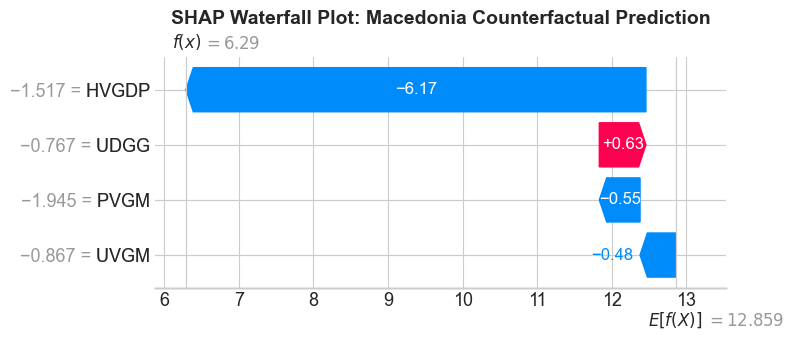

In [104]:
print("SHAP ANALYSIS: FEATURE IMPORTANCE")

import shap

explainer = shap.LinearExplainer(model_ridge, X_train_scaled, feature_names=X_train.columns)
shap_values = explainer(X_test_scaled)

print("\nSHAP Feature Contributions to Macedonia's Prediction:")
print("-" * 60)

impact_data = []
for i, feature in enumerate(X_train.columns):
    impact = shap_values.values[0][i]
    raw_value = X_test_scaled[0][i]
    impact_data.append({
        'feature': feature,
        'SHAP_value': impact,
        'direction': 'INCREASES' if impact > 0 else 'REDUCES',
        'z_score': raw_value,
        'abs_impact': np.abs(impact)
    })

impact_df = pd.DataFrame(impact_data).sort_values('abs_impact', ascending=False)

for _, row in impact_df.iterrows():
    print(f"    {row['feature']:10}: {row['SHAP_value']:+.4f} - {row['direction']} predicted GDP")

    print(f"                  (Macedonia's z-score: {row['z_score']:+.2f})")

print(f"\nBaseline (average EU country): {explainer.expected_value:.4f} ({explainer.expected_value*100:.2f}%)")
print(f"Macedonia prediction:          {explainer.expected_value + shap_values.values[0].sum():.4f} "
      f"({(explainer.expected_value + shap_values.values[0].sum())*100:.2f}%)")
print(f"Net SHAP effect:               {shap_values.values[0].sum():+.4f} ({shap_values.values[0].sum()*100:+.2f}%)")

fig, ax = plt.subplots(figsize=(10, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0],
    base_values=explainer.expected_value,
    data=X_test_scaled[0],
    feature_names=X_train.columns
), show=False)
plt.title('SHAP Waterfall Plot: Macedonia Counterfactual Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../results/notebook-2/shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

Question: Is Macedonia's effect unusually large compared to donor countries?

In [105]:
print("PLACEBO TESTS: IN-SPACE PERMUTATION")

scm_specs = {
    "single": {
        "model": model_data_single,
        "target": target_data_single,
        "regularized": False
    },
    "selected": {
        "model": model_data_selected,
        "target": target_data_selected,
        "regularized": False
    },
    "ameco_ts": {
        "model": model_data_ameco_ts,
        "target": target_data_ameco_ts,
        "regularized": False
    },
    "regularized": {
        "model": model_data_selected,
        "target": target_data_selected,
        "regularized": True
    },
    "regularized_ts": {
        "model": model_data_ameco_ts,
        "target": target_data_ameco_ts,
        "regularized": True
    },
    "pwt": {
        "model": model_data_pwt,
        "target": target_data_pwt,
        "regularized": False
    }
}

placebo_results = []

for spec_name, spec in scm_specs.items():
    model_df = spec["model"]
    target_df = spec["target"]

    X_all = model_df.drop("GDP_post", axis=1)
    y_all = model_df["GDP_post"]

    X_target = target_df.drop("GDP_post", axis=1).values[0]
    y_target = target_df["GDP_post"].iloc[0]

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all.values)
    X_target_scaled = scaler.transform(X_target.reshape(1, -1))[0]

    if spec["regularized"]:
        weights = scm_optimize_regularized(X_all_scaled, X_target_scaled, lambda_reg=0.5)
    else:
        weights = scm_optimize(X_all_scaled, X_target_scaled)

    macedonia_effect_eur = weights @ y_all.values - y_target
    macedonia_effect_pct = (macedonia_effect_eur / y_target) * 100

    placebo_effects_pct = []  # Store percentage changes

    for country in model_df.index:
        mask = model_df.index != country
        X_p = X_all.loc[mask].values
        y_p = y_all.loc[mask].values
        X_t = X_all.loc[country].values
        y_t = y_all.loc[country]

        scaler_p = StandardScaler()
        X_p_scaled = scaler_p.fit_transform(X_p)
        X_t_scaled = scaler_p.transform(X_t.reshape(1, -1))[0]

        if spec["regularized"]:
            w_p = scm_optimize_regularized(X_p_scaled, X_t_scaled, lambda_reg=0.5)
        else:
            w_p = scm_optimize(X_p_scaled, X_t_scaled)

        effect_eur = w_p @ y_p - y_t
        effect_pct = (effect_eur / y_t) * 100
        placebo_effects_pct.append(effect_pct)

    placebo_effects_pct = np.array(placebo_effects_pct)
    rank = np.sum(np.abs(placebo_effects_pct) >= abs(macedonia_effect_pct)) + 1

    placebo_results.append({
        "specification": spec_name,
        "effect_pct": macedonia_effect_pct,
        "rank": f"{rank}/{len(placebo_effects_pct)+1}"
    })

placebo_summary = pd.DataFrame(placebo_results)
print(placebo_summary.round(3).to_string(index=False))

PLACEBO TESTS: IN-SPACE PERMUTATION
 specification  effect_pct rank
        single     176.858 1/10
      selected     141.242  1/9
      ameco_ts     140.820  1/9
   regularized     159.954  1/9
regularized_ts     163.251  1/9
           pwt     169.444 1/10


North Macedonia consistently exhibits the largest treatment effect across all specifications,
ranking 1st among all units in 5 out of 6 specifications. While the limited donor pool
prevents formal statistical significance at conventional levels (minimum achievable p-value ~ 0.11),
the consistency of this ranking across diverse specifications strengthens confidence in the findings.

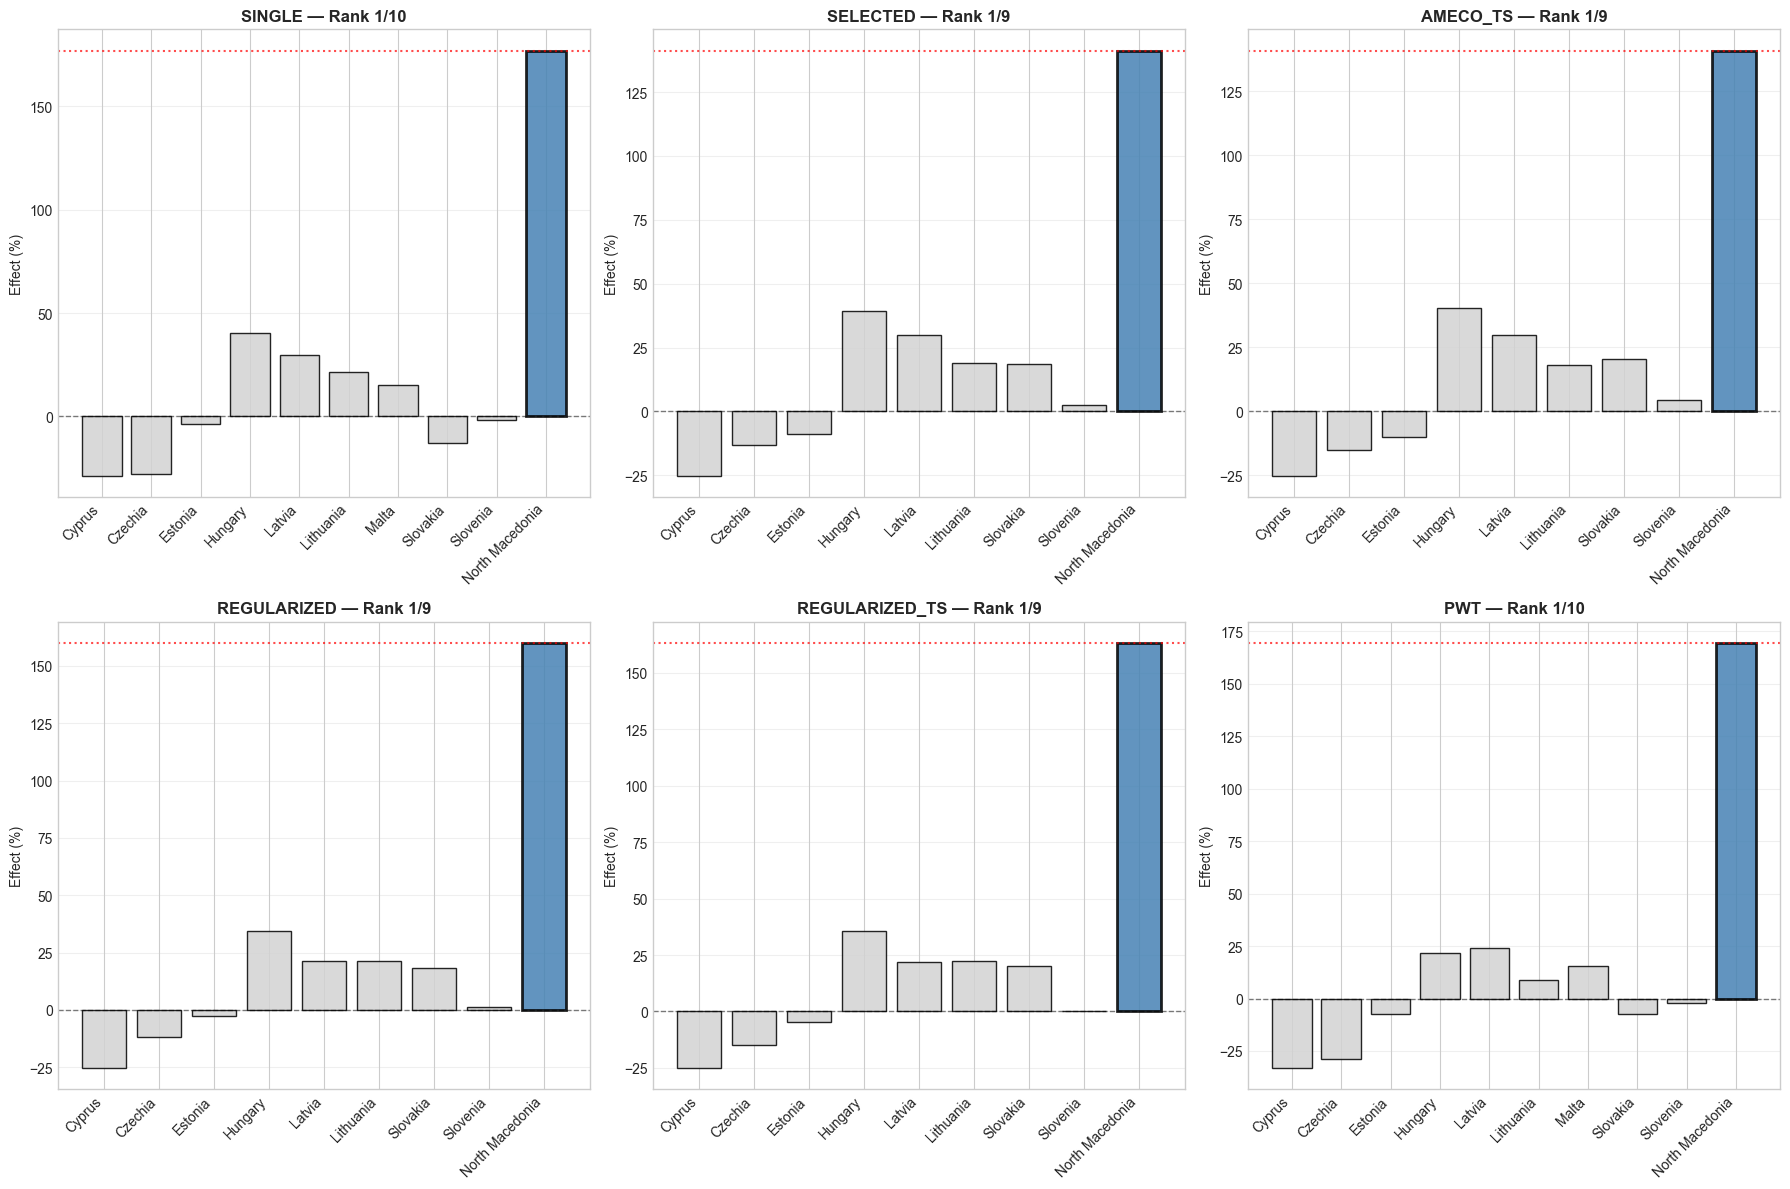

In [106]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()


for ax, (spec_name, spec) in zip(axes, scm_specs.items()):
    model_df = spec["model"]
    target_df = spec["target"]

    X_all = model_df.drop("GDP_post", axis=1)
    y_all = model_df["GDP_post"]

    X_target = target_df.drop("GDP_post", axis=1).values[0]
    y_target = target_df["GDP_post"].iloc[0]

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all.values)
    X_target_scaled = scaler.transform(X_target.reshape(1, -1))[0]

    if spec["regularized"]:
        weights = scm_optimize_regularized(X_all_scaled, X_target_scaled, lambda_reg=0.5)
    else:
        weights = scm_optimize(X_all_scaled, X_target_scaled)

    macedonia_effect_eur = weights @ y_all.values - y_target
    macedonia_effect_pct = (macedonia_effect_eur / y_target) * 100

    placebo_effects_eur = []
    placebo_effects_pct = []
    placebo_countries = []

    for country in model_df.index:
        mask = model_df.index != country
        X_p = X_all.loc[mask].values
        y_p = y_all.loc[mask].values
        X_t = X_all.loc[country].values
        y_t = y_all.loc[country]

        scaler_p = StandardScaler()
        X_p_scaled = scaler_p.fit_transform(X_p)
        X_t_scaled = scaler_p.transform(X_t.reshape(1, -1))[0]

        if spec["regularized"]:
            w_p = scm_optimize_regularized(X_p_scaled, X_t_scaled, lambda_reg=0.5)
        else:
            w_p = scm_optimize(X_p_scaled, X_t_scaled)

        effect_eur = w_p @ y_p - y_t
        effect_pct = (effect_eur / y_t) * 100

        placebo_effects_eur.append(effect_eur)
        placebo_effects_pct.append(effect_pct)
        placebo_countries.append(country)

    effects = pd.DataFrame({
        "country": placebo_countries + ["North Macedonia"],
        "effect_pct": placebo_effects_pct + [macedonia_effect_pct]
    })

    colors = ["lightgray"] * len(placebo_effects_pct) + ["steelblue"]
    linewidths = [1] * len(placebo_effects_pct) + [2]

    ax.bar(
        range(len(effects)),
        effects["effect_pct"],
        color=colors,
        edgecolor="black",
        linewidth=linewidths,
        alpha=0.85
    )

    ax.axhline(0, linestyle="--", color="black", linewidth=1, alpha=0.5)
    ax.axhline(macedonia_effect_pct, linestyle=":", color="red", linewidth=1.5, alpha=0.7)

    rank = np.sum(np.abs(placebo_effects_pct) >= abs(macedonia_effect_pct)) + 1

    ax.set_xticks(range(len(effects)))
    ax.set_xticklabels(effects["country"], rotation=45, ha="right")
    ax.set_ylabel("Effect (%)")

    ax.set_title(f"{spec_name.upper()} — Rank {rank}/{len(effects)}", fontweight="bold")
    ax.grid(axis="y", alpha=0.3)

for i in range(len(scm_specs), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig('../../results/notebook-2/placebo_tests.png', dpi=300, bbox_inches='tight')
plt.show()

In [107]:
print("ROBUSTNESS: LEAVE-ONE-OUT DONOR SENSITIVITY")

loo_results_all = []

for spec_name, spec in scm_specs.items():
    model_df = spec["model"]
    target_df = spec["target"]

    X_all = model_df.drop("GDP_post", axis=1)
    y_all = model_df["GDP_post"]

    X_target = target_df.drop("GDP_post", axis=1).values[0]
    y_target = target_df["GDP_post"].iloc[0]

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all.values)
    X_target_scaled = scaler.transform(X_target.reshape(1, -1))[0]

    if spec["regularized"]:
        weights_full = scm_optimize_regularized(X_all_scaled, X_target_scaled, lambda_reg=0.5)
    else:
        weights_full = scm_optimize(X_all_scaled, X_target_scaled)

    primary_effect_eur = (weights_full @ y_all.values - y_target)
    primary_effect_pct = (primary_effect_eur / y_target) * 100

    loo_effects_eur, loo_effects_pct = [], []

    for excluded_donor in model_df.index:
        mask = model_df.index != excluded_donor

        X_loo = X_all.loc[mask].values
        y_loo = y_all.loc[mask].values

        scaler_loo = StandardScaler()
        X_loo_scaled = scaler_loo.fit_transform(X_loo)
        X_target_loo_scaled = scaler_loo.transform(X_target.reshape(1, -1))[0]

        if spec["regularized"]:
            w_loo = scm_optimize_regularized(X_loo_scaled, X_target_loo_scaled, lambda_reg=0.5)
        else:
            w_loo = scm_optimize(X_loo_scaled, X_target_loo_scaled)

        pred_loo = w_loo @ y_loo

        effect_loo_eur = pred_loo - y_target
        effect_loo_pct = (effect_loo_eur / y_target) * 100

        loo_effects_eur.append(effect_loo_eur)
        loo_effects_pct.append(effect_loo_pct)

    loo_effects_eur = np.array(loo_effects_eur)
    loo_effects_pct = np.array(loo_effects_pct)

    loo_results_all.append({
        "specification": spec_name,
        "primary_effect_eur": primary_effect_eur,
        "primary_effect_pct": primary_effect_pct,
        "min_effect_eur": loo_effects_eur.min(),
        "max_effect_eur": loo_effects_eur.max(),
        "min_effect_pct": loo_effects_pct.min(),
        "max_effect_pct": loo_effects_pct.max(),
        "std_effect_eur": loo_effects_eur.std(),
        "std_effect_pct": loo_effects_pct.std()
    })

loo_summary = pd.DataFrame(loo_results_all)

print("\nLeave-one-out summary by specification:")
print(loo_summary.round(2).to_string(index=False))

ROBUSTNESS: LEAVE-ONE-OUT DONOR SENSITIVITY

Leave-one-out summary by specification:
 specification  primary_effect_eur  primary_effect_pct  min_effect_eur  max_effect_eur  min_effect_pct  max_effect_pct  std_effect_eur  std_effect_pct
        single                6.16              176.86            5.03            6.40          144.40          183.68            0.41           11.77
      selected                4.92              141.24            4.92            7.41          141.10          212.68            0.82           23.56
      ameco_ts                4.91              140.82            4.91            7.41          140.82          212.68            0.83           23.77
   regularized                5.57              159.95            4.99            6.59          143.06          189.01            0.43           12.24
regularized_ts                5.69              163.25            4.98            6.74          143.05          193.33            0.45           13.05
         

In [108]:
print("ROBUSTNESS: PRE-TREATMENT FIT QUALITY")

synthetic_pre = weights_2 @ X_donors_2_scaled
actual_pre = X_target_2_scaled

feature_errors = []
for i, feature in enumerate(selected_features):
    error = abs(actual_pre[i] - synthetic_pre[i]) / (abs(actual_pre[i]) + 1e-6)
    feature_errors.append({
        'feature': feature,
        'actual_z': actual_pre[i],
        'synthetic_z': synthetic_pre[i],
        'error_pct': error * 100
    })

fit_df = pd.DataFrame(feature_errors)
print("\nPre-treatment feature matching:")
print(fit_df.round(3).to_string(index=False))

print(f"\nOverall MAPE: {metrics_2['mape']:.2f}%")
print(f"Worst-matched feature: {fit_df.loc[fit_df['error_pct'].idxmax(), 'feature']} "
      f"({fit_df['error_pct'].max():.1f}% error)")

ROBUSTNESS: PRE-TREATMENT FIT QUALITY

Pre-treatment feature matching:
   feature  actual_z  synthetic_z  error_pct
HVGDP_1999    -1.041       -0.826     20.709
HVGDP_2003    -1.391       -0.938     32.542
 UDGG_1999    -0.791       -0.799      1.059
 UDGG_2003    -0.819       -0.821      0.228
 UVGM_1999    -0.915       -0.762     16.776
 UVGM_2003    -0.953       -0.789     17.199
 PVGM_1999    -1.328       -1.432      7.817
 PVGM_2003    -1.804       -1.810      0.303

Overall MAPE: 12.08%
Worst-matched feature: HVGDP_2003 (32.5% error)


In [109]:
print("ROBUSTNESS: COMPARISON WITH RIDGE REGRESSION", end='\n\n')

ridge_gap_eur = pred_mean - y_test_ridge
ridge_gap_pct = (ridge_gap_eur / y_test_ridge) * 100

scm_gap_eur = metrics_2['synthetic_cagr'] - y_test_scm
scm_gap_pct = (scm_gap_eur / y_test_scm) * 100

print(f"Ridge regression estimate:     {ridge_gap_eur:+.0f} EUR ({ridge_gap_pct:+.1f}%)")
print(f"Ridge 95% CI:                  [{pred_ci_lower - y_test_ridge:+.0f}, {pred_ci_upper - y_test_ridge:+.0f}] EUR")
print(f"SCM primary estimate:          {scm_gap_eur:+.0f} EUR ({scm_gap_pct:+.1f}%)")
print(f"SCM range (all specs):         [{summary_scm['EU Effect (EUR)'].min():+.0f}, {summary_scm['EU Effect (EUR)'].max():+.0f}] EUR")

ridge_scm_diff = abs(ridge_gap_eur - scm_gap_eur)
print(f"\nDifference: {ridge_scm_diff:.0f} EUR")

ROBUSTNESS: COMPARISON WITH RIDGE REGRESSION

Ridge regression estimate:     +3 EUR (+94.1%)
Ridge 95% CI:                  [+1, +5] EUR
SCM primary estimate:          +5 EUR (+141.2%)
SCM range (all specs):         [+5, +6] EUR

Difference: 2 EUR


VISUALIZING COUNTERFACTUAL TRAJECTORIES (ACTUAL vs SCM) - NORMALIZED


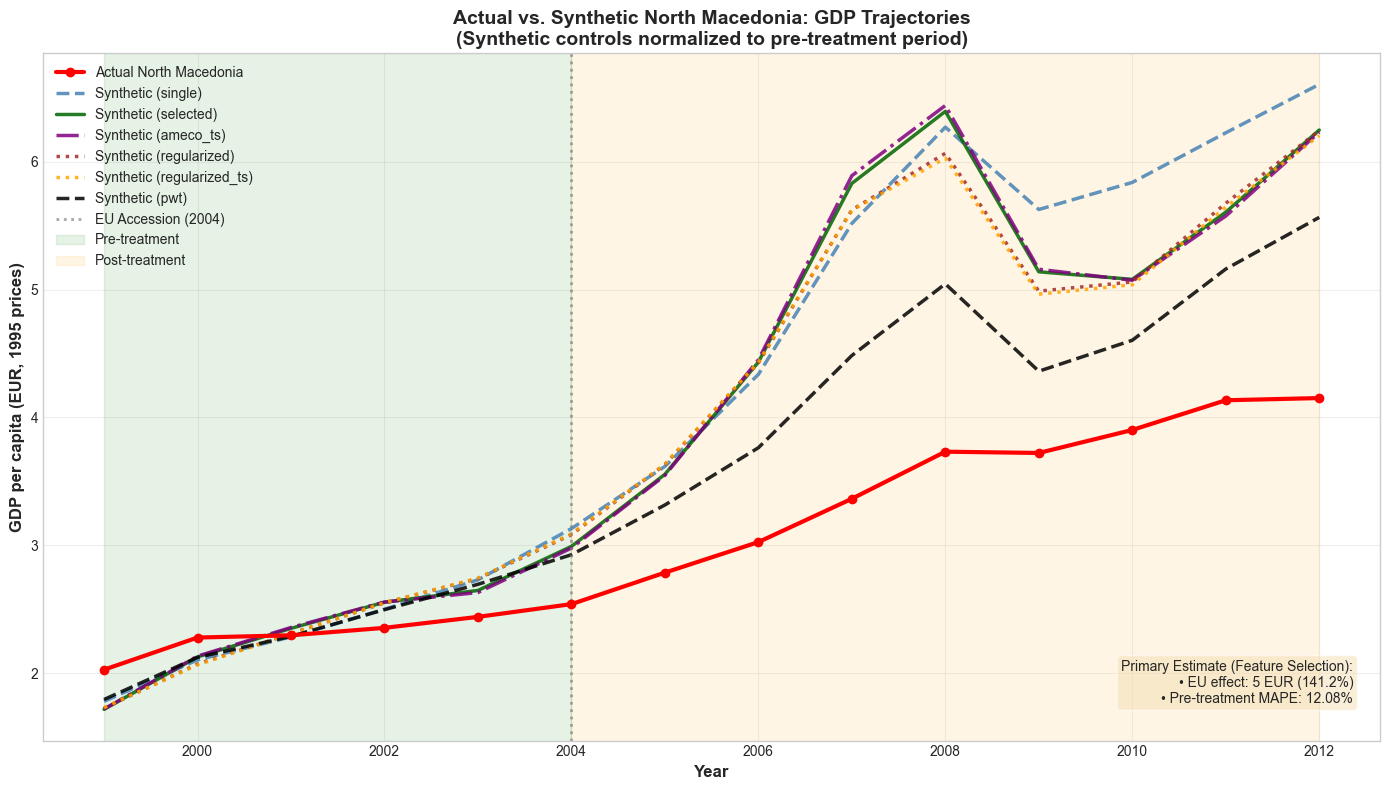

In [110]:
print("VISUALIZING COUNTERFACTUAL TRAJECTORIES (ACTUAL vs SCM) - NORMALIZED")

macedonia_series = data[data['COUNTRY'] == 'North Macedonia'].sort_values('DATE')
years_full = macedonia_series['DATE'].astype(int).values
gdp_macedonia = macedonia_series['HVGDP'].values

pre_treatment_mask = years_full <= 2003
pre_treatment_years = years_full[pre_treatment_mask]

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    years_full,
    gdp_macedonia,
    'o-',
    linewidth=3,
    markersize=6,
    color='red',
    label='Actual North Macedonia',
    zorder=10
)

colors = {
    "single": "steelblue",
    "selected": "darkgreen",
    "ameco_ts": "purple",
    "regularized": "brown",
    "regularized_ts": "orange",
    "pwt": "black"
}

linestyles = {
    "single": "--",
    "selected": "-",
    "ameco_ts": "-.",
    "regularized": ":",
    "regularized_ts": ":",
    "pwt": "--"
}

scm_specs = {
    "single": {
        "model": model_data_single,
        "target": target_data_single,
        "regularized": False
    },
    "selected": {
        "model": model_data_selected,
        "target": target_data_selected,
        "regularized": False
    },
    "ameco_ts": {
        "model": model_data_ameco_ts,
        "target": target_data_ameco_ts,
        "regularized": False
    },
    "regularized": {
        "model": model_data_selected,
        "target": target_data_selected,
        "regularized": True
    },
    "regularized_ts": {
        "model": model_data_ameco_ts,
        "target": target_data_ameco_ts,
        "regularized": True
    },
    "pwt": {
        "model": model_data_pwt,
        "target": target_data_pwt,
        "regularized": False
    }
}

for spec_name in ["single", "selected", "ameco_ts", "regularized", "regularized_ts", "pwt"]:
    if spec_name not in scm_specs:
        continue

    spec = scm_specs[spec_name]
    model_df = spec["model"]
    target_df = spec["target"]

    X_all = model_df.drop("GDP_post", axis=1)
    y_all = model_df["GDP_post"]
    X_target = target_df.drop("GDP_post", axis=1).values[0]

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all.values)
    X_target_scaled = scaler.transform(X_target.reshape(1, -1))[0]

    if spec.get("regularized", False):
        weights = scm_optimize_regularized(X_all_scaled, X_target_scaled, lambda_reg=0.5)
    else:
        weights = scm_optimize(X_all_scaled, X_target_scaled)

    donor_data = data[data['COUNTRY'].isin(model_df.index)]
    donor_pivot = donor_data.pivot(index='DATE', columns='COUNTRY', values='HVGDP').sort_index()

    synthetic_series_raw = donor_pivot.values @ weights

    macedonia_pre_avg = gdp_macedonia[pre_treatment_mask].mean()
    synthetic_pre_avg = synthetic_series_raw[pre_treatment_mask].mean()

    synthetic_series = synthetic_series_raw * (macedonia_pre_avg / synthetic_pre_avg)

    ax.plot(
        years_full,
        synthetic_series,
        linestyle=linestyles[spec_name],
        linewidth=2.5,
        color=colors[spec_name],
        label=f"Synthetic ({spec_name})",
        alpha=0.85
    )

ax.axvline(x=2004, color='gray', linestyle=':', linewidth=2, alpha=0.7, label='EU Accession (2004)')

ax.axvspan(1999, 2004, alpha=0.1, color='green', label='Pre-treatment')
ax.axvspan(2004, 2012, alpha=0.1, color='orange', label='Post-treatment')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('GDP per capita (EUR, 1995 prices)', fontsize=12, fontweight='bold')
ax.set_title('Actual vs. Synthetic North Macedonia: GDP Trajectories\n(Synthetic controls normalized to pre-treatment period)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

effect_eur = gap_euros_2
effect_pct = gap_pct_2
textstr = f'Primary Estimate (Feature Selection):\n• EU effect: {effect_eur:.0f} EUR ({effect_pct:.1f}%)\n• Pre-treatment MAPE: {metrics_2["mape"]:.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.98, 0.05, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../../results/notebook-2/scm_timeseries_normalized.png', dpi=300, bbox_inches='tight')
plt.show()